# Time-Optimal Control Exercise

In [1]:
import os
import time
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import (
    MX, DM, Function, Opti, integrator,
    vec, vcat, vertcat, horzcat, 
    sum1, sum2, sumsqr, sin, cos,
    gradient, jacobian, hessian
)

import casadi
casadi.__version__

'3.6.5'

In [2]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [3]:
# Physical constants

T = 1.0  # control horizon [s]
N = 20  # Number of control intervals

dt = T / N  # length of 1 control interval [s]

tgrid = np.linspace(0, T, N+1)

## Define continuous-time system

$\dot{x} = f(x,u)$

In [4]:
nx = 4

# Construct function for the ODE right-hand side
x = MX.sym('x', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
u = MX.sym('u', 2)  # control force [N]
rhs = vertcat(x[2:4], u)

# Continuous system dynamics as a CasADi Function
f = Function('f', [x, u], [rhs])
f

Function(f:(i0[4],i1[2])->(o0[4]) MXFunction)

## Define discrete-time system

$x_{k+1} = F(x_k, u_k)$

In [5]:
# Construct function for the ODE right-hand side
xk = MX.sym('xk', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
uk = MX.sym('uk', 2)  # control force [N]

f1 = f(xk, uk)
f2 = f(xk + dt/2 * f1, uk)
f3 = f(xk + dt/2 * f2, uk)
f4 = f(xk + dt * f3, uk)
xkp1 = xk + dt / 6 * (f1 + 2 * f2 + 2 * f3 + f4)

F = Function('F', [xk, uk], [xkp1], ['xk', 'uk'], ['xkp1'])
F

Function(F:(xk[4],uk[2])->(xkp1[4]) MXFunction)

## Waypoints

In [6]:
ref = horzcat(sin(np.linspace(0, 2, N+1)), cos(np.linspace(0,2,N+1))).T
ref.shape

(2, 21)

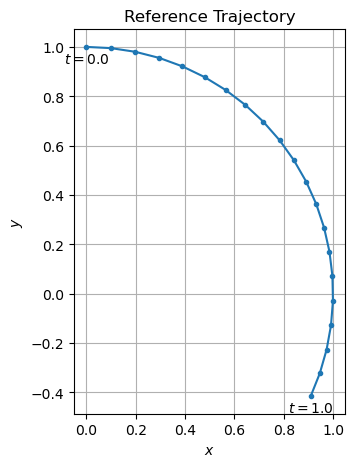

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 5.5))
ax.plot(ref[0, :].T, ref[1, :].T, '.-')
xy0 = np.array(ref[:, 0])
ax.annotate(f'$t={tgrid[0]}$', xy=xy0, xytext=(0, -5), textcoords='offset pixels', va='top', ha='center')
xy_end = np.array(ref[:, -1])
ax.annotate(f'$t={tgrid[-1]}$', xy=xy_end, xytext=(0, -5), textcoords='offset pixels', va='top', ha='center')
ax.grid()
ax.set_aspect('equal')
ax.set_title('Reference Trajectory')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.show()

## 1.1. Run the reference multiple-shooting implementation

Set up optimal control problem

In [8]:
opti = casadi.Opti()

# Decision variables for states
X = opti.variable(nx, N + 1)

# Decision variables for control vector
U = opti.variable(2, N) # force [N]

# Gap-closing shooting constraints
for k in range(N):
  opti.subject_to(X[:, k+1] == F(X[:, k], U[:, k]))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3)) # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3)) # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3)) # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3)) # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10)) # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10)) # force_x limits

# Initial constraints
#opti.subject_to(X[:, 0] == vertcat(ref[:, 0], 0, 0))
# Alternative initial constraints
opti.subject_to(X[:2, 0] == ref[:, 0])

# Try to follow the waypoints
opti.minimize(sumsqr(X[:2, :] - ref))
opti

Opti(Opti {
  instance #0
  #variables: 2 (nx = 124)
  #parameters: 0 (np = 0)
  #constraints: 27 (ng = 206)
  CasADi solver needs updating.
})

In [9]:
# Use IPOPT solver
opti.solver('ipopt')

sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      282
Number of nonzeros in inequality constraint Jacobian.:      124
Number of nonzeros in Lagrangian Hessian.............:       42

Total number of variables............................:      124
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       82
Total number of inequality c

In [10]:
# Tracking error
tracking_rmse = np.sqrt(sol.value(sumsqr(X[:2, :] - ref)) / (N + 1))
tracking_rmse

9.223482738517469e-08

Plot Solution

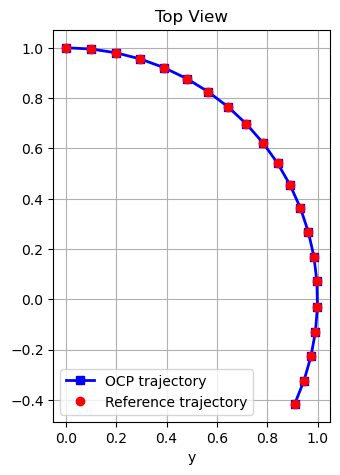

In [11]:
def make_trajectory_plot(xsol, ref):
    fig, ax = plt.subplots(figsize=(3.5, 5.5))
    ax.plot(xsol[0, :].T, xsol[1, :].T, 'bs-', linewidth=2, label='OCP trajectory')
    ax.plot(ref[0, :].T, ref[1, :].T, 'ro', linewidth=3, label='Reference trajectory')
    ax.legend()
    ax.set_xlabel('x')
    ax.set_xlabel('y')
    ax.set_aspect('equal')
    ax.grid()
    ax.set_title('Top View')

xsol = sol.value(X)
make_trajectory_plot(xsol, ref)
plt.tight_layout()
filename = f'toc_sol_1_1_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

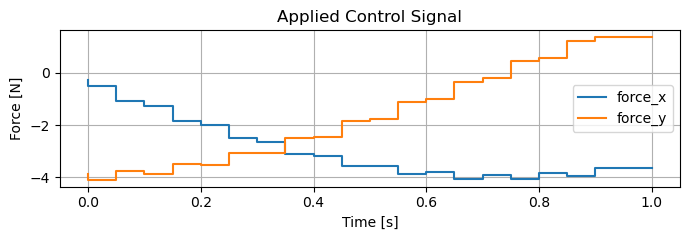

In [12]:
def make_control_signal_plot(usol):
    plt.figure(figsize=(7, 2.5))
    plt.step(tgrid, horzcat(usol, usol[:, -1]).T)
    plt.title('Applied Control Signal')
    plt.legend(('force_x', 'force_y'))
    plt.ylabel('Force [N]')
    plt.xlabel('Time [s]')
    plt.grid()

usol = sol.value(U)
make_control_signal_plot(usol)
plt.tight_layout()
filename = f'toc_sol_1_1_control.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

The reason the optimal solution does not match the reference trajectory is that the reference trajectory is not a feasible solution to the problem as we have defined it above.

The initial state is constrained to `vertcat(ref[:, 0], 0, 0))` which means the particle is stationary. Yet the reference trajectory looks like it is based on a particle that is moving at constant speed in a circle.

### 1.2 Integration using explicit Euler method and QP solver

In [23]:
# Construct function for the ODE right-hand side
xk = MX.sym('xk', nx)  # states: pos_x [m], pos_y [m], vel_x [m/s], vel_y [m/s]
uk = MX.sym('uk', 2)  # control force [N]

# Integration using explicit Euler method
xkp1 = xk + dt * f(xk, uk)

F1 = Function('F1', [xk, uk], [xkp1], ['xk', 'uk'], ['xkp1'])
F1

Function(F1:(xk[4],uk[2])->(xkp1[4]) MXFunction)

In [24]:
opti = casadi.Opti()

# Decision variables for states
X = opti.variable(nx, N + 1)

# Decision variables for control vector
U = opti.variable(2, N) # force [N]

# Gap-closing shooting constraints
for k in range(N):
  opti.subject_to(X[:, k+1] == F1(X[:, k], U[:, k]))

# Path constraints
opti.subject_to(opti.bounded(-3, X[0, :], 3)) # pos_x limits
opti.subject_to(opti.bounded(-3, X[1, :], 3)) # pos_y limits
opti.subject_to(opti.bounded(-3, X[2, :], 3)) # vel_x limits
opti.subject_to(opti.bounded(-3, X[3, :], 3)) # vel_y limits
opti.subject_to(opti.bounded(-10, U[0, :], 10)) # force_x limits
opti.subject_to(opti.bounded(-10, U[1, :], 10)) # force_x limits

# Initial constraints
opti.subject_to(X[:2, 0] == ref[:, 0])

# Try to follow the waypoints
opti.minimize(sumsqr(X[:2, :] - ref))
opti

Opti(Opti {
  instance #2
  #variables: 2 (nx = 124)
  #parameters: 0 (np = 0)
  #constraints: 27 (ng = 206)
  CasADi solver needs updating.
})

In [28]:
# Use SQP solver
options = {'qpsol': 'qrqp'}
# Silence optimizer outputs
# options["qpsol_options"] = {"print_iter": False, "print_header": False}
# options["print_iteration"] = False
# options["print_header"] = False
# options["print_status"] = False
# options["print_time"] = False
opti.solver('sqpmethod', options)

#opti.solver('sqpmethod')

sol = opti.solve()

-------------------------------------------
This is casadi::QRQP
Number of variables:                             124
Number of constraints:                           206
Number of nonzeros in H:                          42
Number of nonzeros in A:                         366
Number of nonzeros in KKT:                      1062
Number of nonzeros in QR(V):                     814
Number of nonzeros in QR(R):                    1446
-------------------------------------------
This is casadi::Sqpmethod.
Using exact Hessian
Number of variables:                             124
Number of constraints:                           206
Number of nonzeros in constraint Jacobian:       366
Number of nonzeros in Lagrangian Hessian:         42

iter      objective    inf_pr    inf_du     ||d||  lg(rg) ls    info
   0   2.100000e+01  1.00e+00  2.00e+00  0.00e+00       -  0  - 
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     2         0         1   329   

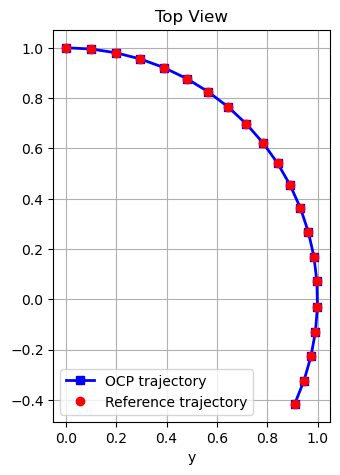

In [29]:
xsol = sol.value(X)
make_trajectory_plot(xsol, ref)
plt.tight_layout()
filename = f'toc_sol_1_2_top_view.pdf'
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

In [30]:
# Tracking error
tracking_rmse = np.sqrt(sol.value(sumsqr(X[:2, :] - ref)) / (N + 1))
tracking_rmse

4.108238478795633e-16